In [177]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime as dt
import seaborn as sns
import tensorflow as tf


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [178]:
df = pd.read_csv("Dataset.csv")
tickers = df.groupby('Ticker')
dates = df.date.unique()
dates = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]

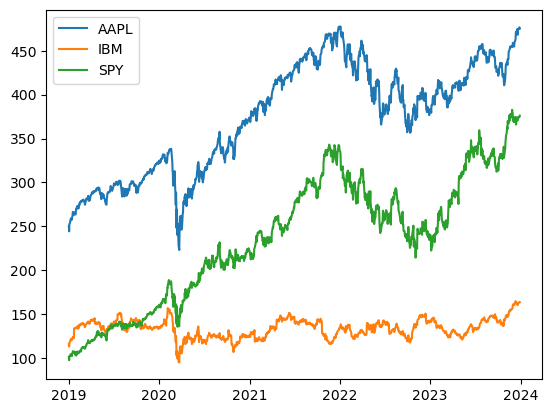

In [179]:
for name, data in tickers:
    plt.plot(dates, data.PRC.values, '-', label = name)
plt.legend()

In [180]:

def ts_split(ts, feature_steps=10, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps].flatten() for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps][:, -1]
                  for idx in range(n_obs)])
    return X, y
    '''
def ts_split(ts, feature_steps=10, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps] for idx in range(n_obs)])  # Extract all features as the target
    return X, y
'''

In [ ]:
ts = {}
X = {}
y = {}
X_train_full = {}
y_train_full = {}
X_test = {}
y_test = {}
X_train = {}
y_train = {}
X_valid = {}
y_valid = {}
split_ind = {}
split_ind_2 = {}

features = ['PRC']  #features
scalers = {}



In [182]:
from sklearn.preprocessing import MinMaxScaler

# The variables are already defined in CELL INDEX: 6, no need to redefine them
#target = 'PRC'  # Define the target column

for name, data in tickers:
    data = data[features].dropna()
    #scalers[name] = StandardScaler()   
    scalers[name] = MinMaxScaler()
    data[features] = scalers[name].fit_transform(data[features])
    ts[name] = data[features].values
    
    X[name], y[name] = ts_split(ts[name])
    split_ind[name] = int(X[name].shape[0] * 0.8)
    X_train_full[name], y_train_full[name] = X[name][:split_ind[name]], y[name][:split_ind[name]]
    X_test[name], y_test[name] = X[name][split_ind[name]:], y[name][split_ind[name]:]
    split_ind_2[name] = int(X_train_full[name].shape[0] * 0.8)
    X_train[name], y_train[name] = X_train_full[name][:split_ind_2[name]], y_train_full[name][:split_ind_2[name]]
    X_valid[name], y_valid[name] = X_train_full[name][split_ind_2[name]:], y_train_full[name][split_ind_2[name]:]

In [183]:

#print(len(y_train_full['SPY']))
#print(len(X_train_full['SPY']))
#print(y_test['SPY'][1])
print(X_train['SPY'].shape)
print(y_train['SPY'].shape)
#print(data[features].shape)
print(data[features].shape)
print(ts['AAPL'])

(798, 10)
(798, 1)
(1258, 1)
[[0.10688488]
 [0.08345113]
 [0.11555975]
 ...
 [0.99528976]
 [0.99599627]
 [0.99057941]]


In [184]:
print(X_test['SPY'].shape)
print(y_train['SPY'].shape)
print(X_valid['SPY'][:1])
print(X_train['SPY'][:1])

(250, 10)
(798, 1)
[[0.69582896 0.67458809 0.63620748 0.62548196 0.66982122 0.65962143
  0.64027341 0.62754993 0.66508932 0.69046619]]
[[0.01303891 0.         0.01587802 0.01633368 0.01892744 0.02407992
  0.02173151 0.01892744 0.01629863 0.02667368]]


In [185]:
print(f"Training mean: {X_train['AAPL'].mean()}, Validation mean: {X_valid['AAPL'].mean()}")
print(f"Training std: {X_train['AAPL'].std()}, Validation std: {X_valid['AAPL'].std()}")


Training mean: 0.5080742419197254, Validation mean: 0.6993447863025901
Training std: 0.2585292362987853, Validation std: 0.09623431027365312


In [197]:
from keras.layers import BatchNormalization
from keras.layers import LayerNormalization
def simpleRNN_DO(input_shape, output_units):
    model= Sequential()
    model.add(SimpleRNN(units = 64, activation='relu', input_shape = input_shape,return_sequences= True))
    model.add(Dropout(0.2))
    #model.add(BatchNormalization())

    model.add(SimpleRNN(units= 64, activation = 'relu', return_sequences= True))
    model.add(Dropout(0.2))
    #model.add(BatchNormalization())

    model.add(SimpleRNN(units = 64, activation='relu',return_sequences= False))
    #model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    #model.add(SimpleRNN(units = 64, activation= 'tanh'))
    

    #model.add(BatchNormalization())
    #model.add(LayerNormalization())
    model.add(Dense(units= output_units))
    return model

In [198]:
def reset_session(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

Training model for ticker: AAPL
X_train shape: (798, 10), y_train shape: (798, 1)
X_valid shape: (200, 10), y_valid shape: (200, 1)


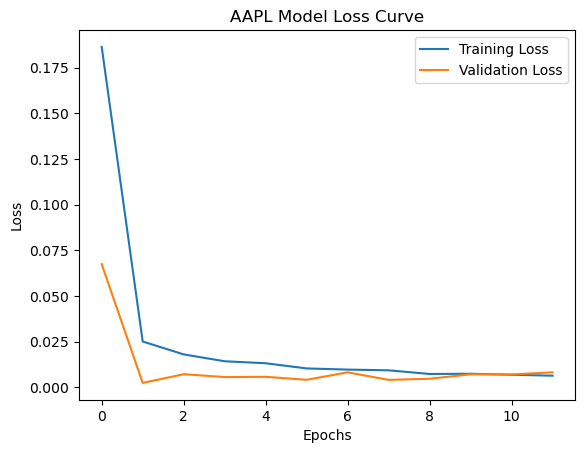

Test loss for AAPL: 0.0006878292770124972
Training model for ticker: IBM
X_train shape: (798, 10), y_train shape: (798, 1)
X_valid shape: (200, 10), y_valid shape: (200, 1)


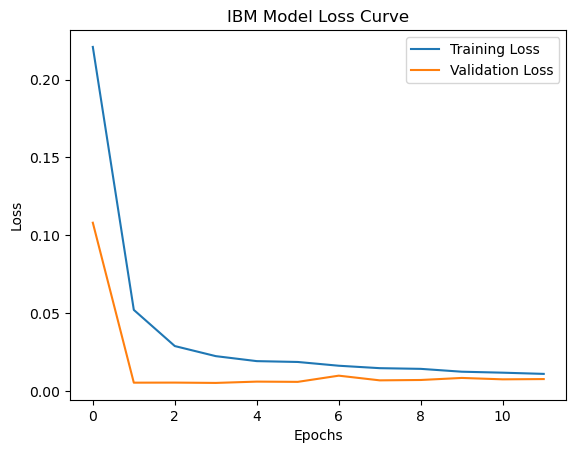

Test loss for IBM: 0.0034432674292474985
Training model for ticker: SPY
X_train shape: (798, 10), y_train shape: (798, 1)
X_valid shape: (200, 10), y_valid shape: (200, 1)


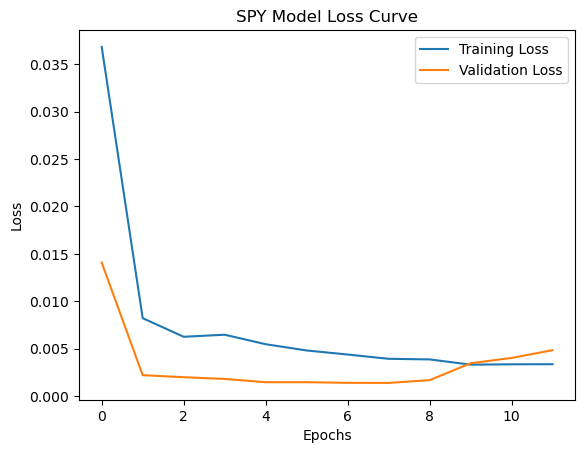

Test loss for SPY: 0.004831588827073574


In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.optimizers import Adam
#import random
reset_session(42)
models = {}
histories = {}

for name in tickers.groups.keys():
    # Determine input shape for the RNN (timesteps, features)
    input_shape = (X_train[name].shape[1], 1)  # Assuming X_train is (samples, timesteps, features)
    output_units = y_train[name].shape[1]   # Determine number of output units
    
    # Build RNN model
    model = simpleRNN_DO(input_shape, output_units)
    #model.add(SimpleRNN(units=50, activation='relu', input_shape=input_shape))
    #model.add(Dropout(0.2))  # Add dropout for regularization
    #model.add(Dense(units=output_units))  # Output layer
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer= optimizer, loss='mean_squared_error')  # Compile the model
    
    y_train_values = y_train[name]  # Keep the y values without reshaping
    y_valid_values = y_valid[name]  # Validation y values without reshaping
  
    
    # X_train and X_valid are already correctly shaped for RNN (no need for reshaping here)
    print(f"Training model for ticker: {name}")
    print(f"X_train shape: {X_train[name].shape}, y_train shape: {y_train_values.shape}")
    print(f"X_valid shape: {X_valid[name].shape}, y_valid shape: {y_valid_values.shape}")
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                min_delta=0.01,
                                                restore_best_weights=True)
    # Ensure X and y have matching number of samples
    if len(X_train[name]) == len(y_train_values):
        history = model.fit(X_train[name], y_train_values, epochs=100, batch_size=32,
                            validation_data=(X_valid[name], y_valid_values),
                            callbacks=[early_stopping_cb], verbose=0)
        models[name] = model
        histories[name] = history
        model.save(f'simpleRNN_model_{name}.h5') # Save the model
    
        
        
        # Plotting loss curves
        plt.figure()
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f"{name} Model Loss Curve")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    test_loss = model.evaluate(X_test[name], y_test[name], verbose=0)
    print(f"Test loss for {name}: {test_loss}")



In [150]:
for name in tickers.groups.keys():
    print(f"Shape of X_train[name]: {X_train[name].shape}")


Shape of X_train[name]: (798, 10)
Shape of X_train[name]: (798, 10)
Shape of X_train[name]: (798, 10)


In [203]:
from sklearn.metrics import mean_squared_error

# Plotting the model's prediction on the test set for each ticker

for name, model in models.items():
    X_test_values = X_test[name]  # Use the correctly shaped X_test values

    y_test_values = y_test[name]
    y_pred = model.predict(X_test_values)
    
    

    # Adjust for single or multiple output features
    #y_test_values = y_test_values.reshape(-1, 1) if len(y_test_values.shape) == 1 else y_test_values
    #y_pred = y_pred.reshape(-1, 1) if len(y_pred.shape) == 1 else y_pred
    
    mse = mean_squared_error(y_test_values, y_pred)
    print(f'Ticker: {name} - MSE: {mse}')

    # Plotting actual vs predicted for each feature
    #print(y_test_values.reshape(-1,1).shape)
    #plt.figure(figsize=(10, 6))
    #for i, feature in enumerate(features):
        #if y_test_values.shape[1] > i:  # Ensure index is within bounds
            #plt.plot(range(len(y_test_values)), y_test_values[:, i], label=f'Actual {feature}', linestyle='-', marker='o')
            #plt.plot(range(len(y_pred)), y_pred[:, i], label=f'Predicted {feature}', linestyle='-', marker='x')
    #plt.title(f'Ticker: {name} - Actual vs Predicted on Test Set')
    #plt.xlabel('Time Step')
    #plt.ylabel('Values (scaled)')
    #plt.legend()
    #plt.show()

8/8 [==============================] - 0s 5ms/step
Ticker: AAPL - MSE: 0.0006878293383919012
8/8 [==============================] - 1s 6ms/step
Ticker: IBM - MSE: 0.003443267517249101
8/8 [==============================] - 1s 5ms/step
Ticker: SPY - MSE: 0.004831588641999709


8/8 [==============================] - 0s 9ms/step
Ticker: AAPL - MSE: 44.64197041745842
Test Loss: 0.004831588827073574


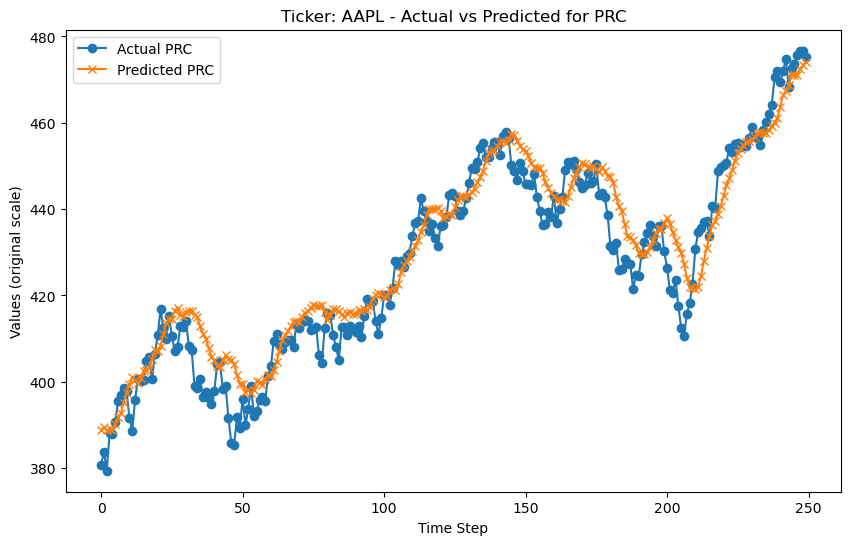

8/8 [==============================] - 0s 5ms/step
Ticker: IBM - MSE: 16.84311151991835
Test Loss: 0.004831588827073574


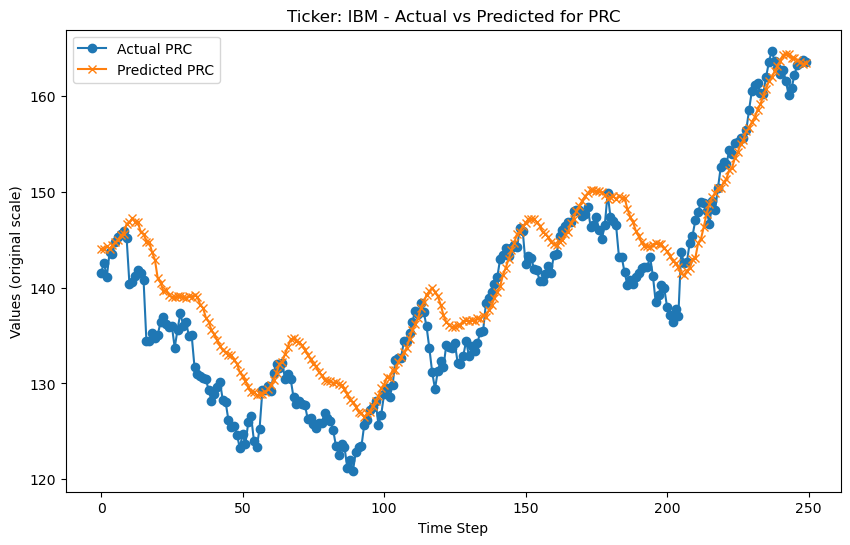

8/8 [==============================] - 0s 6ms/step
Ticker: SPY - MSE: 393.2726520745216
Test Loss: 0.004831588827073574


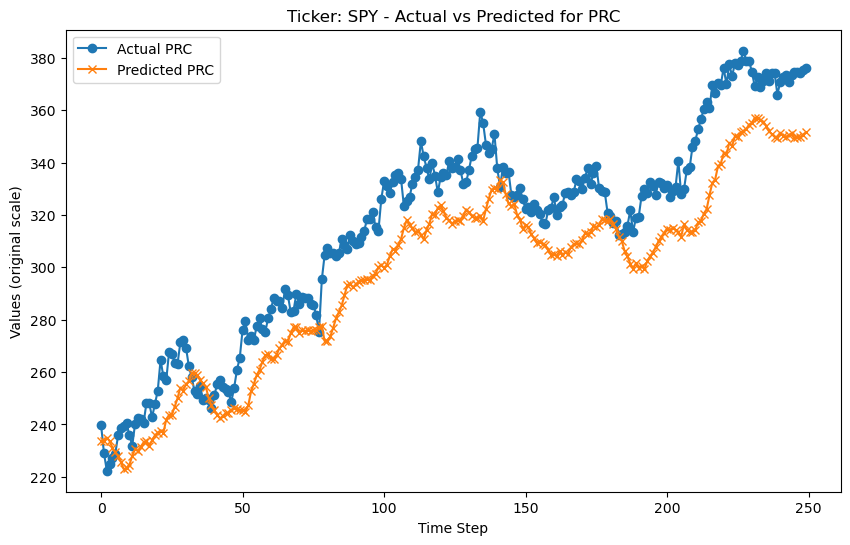

In [204]:
# Loop through each ticker
for name in tickers.groups.keys():
    # Make predictions for the current ticker
    y_test_values = y_test[name]
    y_pred = models[name].predict(X_test[name])

    # Inverse transform predictions and test values to original scale
    y_test_original = scalers[name].inverse_transform(y_test_values)
    y_pred_original = scalers[name].inverse_transform(y_pred)
    mse = mean_squared_error(y_test_original, y_pred_original)
    print(f'Ticker: {name} - MSE: {mse}')
    # Evaluate on a separate test set if available
   
    print(f"Test Loss: {test_loss}")


    # Loop through each feature to plot separately
    for i, feature in enumerate(features):
        if y_test_original.shape[1] > i:  # Ensure index is within bounds
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(y_test_original)), y_test_original[:, i], label=f'Actual {feature}', linestyle='-', marker='o')
            plt.plot(range(len(y_pred_original)), y_pred_original[:, i], label=f'Predicted {feature}', linestyle='-', marker='x')
            plt.title(f'Ticker: {name} - Actual vs Predicted for {feature}')
            plt.xlabel('Time Step')
            plt.ylabel('Values (original scale)')
            plt.legend()
            plt.show()
